<h1 align="center">Data Science for Algorithmic Marketing</h1>

<h2 align="center">Final Project</h2>

<h3 align="center">Group 5: Roselyn R., Adela C., and Mike M.</h3>

# Table of Contents <a class="anchor" id="home"></a>

1. [Packages and Dataset](#Packages-and-Dataset)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Association Rules Algorithm](#Association-Rules-Algorithm)
   * [Pre-Processing](#Pre-Processing)
   * [Baskets](#Baskets)
   * [Top 10 Association Rules for Europe](#Top-10-Association-Rules-for-Europe)
   * [Top 10 Frequent Item Sets (Bundles of At Least 2) - Based on Relative Support](#Top-10-Frequent-Item-Sets-(Bundles-of-At-Least-2)-Based-on-Relative-Support)
   * [Marketing Insights](#Marketing-Insights)  
4. [K-Means](#K-Means)
   * [Pre-Processing](#Pre-Processing-2)
   * [Feature Engineering](#Feature-Engineering)
   * [Train/Test Split](#Train/Test-Split)
   * [K-Means Solution](#K-Means-Solution)
   * [Choosing K](#Choosing-K)
   * [Cluster Interpretations / Marketing Insights](#Cluster-Interpretations/Marketing-Insights)

# Packages and Dataset <a class="anchor" id="Packages-and-Dataset"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#Association Rules
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#K-Means
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [4]:
ecommerce = pd.read_csv('ecommerce_data.csv', encoding="ISO-8859-1")

# Exploratory Data Analysis <a class="anchor" id="Exploratory-Data-Analysis"></a>

In [5]:
ecommerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


In [6]:
ecommerce.shape

(541909, 8)

In [7]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
ecommerce.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
ecommerce.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000,541909.000,406829.000
mean,9.552,4.611,15287.691
std,218.081,96.760,1713.600
min,-80995.000,-11062.060,12346.000
25%,1.000,1.250,13953.000
50%,3.000,2.080,15152.000
75%,10.000,4.130,16791.000
max,80995.000,38970.000,18287.000


In [10]:
for column in ecommerce.columns:
    unique_values = ecommerce[column].unique()
    print(f"\n{column}: {unique_values}")


InvoiceNo: ['536365' '536366' '536367' ... '581585' '581586' '581587']

StockCode: ['85123A' '71053' '84406B' ... '90214U' '47591b' '23843']

Description: ['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']

Quantity: [     6      8      2     32      3      4     24     12     48     18
     20     36     80     64     10    120     96     23      5      1
     -1     50     40    100    192    432    144    288    -12    -24
     16      9    128     25     30     28      7     56     72    200
    600    480     -6     14     -2     11     33     13     -4     -5
     -7     -3     70    252     60    216    384    -10     27     15
     22     19     17     21     34     47    108     52  -9360    -38
     75    270     42    240     90    320   1824    204     69    -36
   -192   -144    160   2880   1400     39    -48    -50     26   1440
     31     82     7

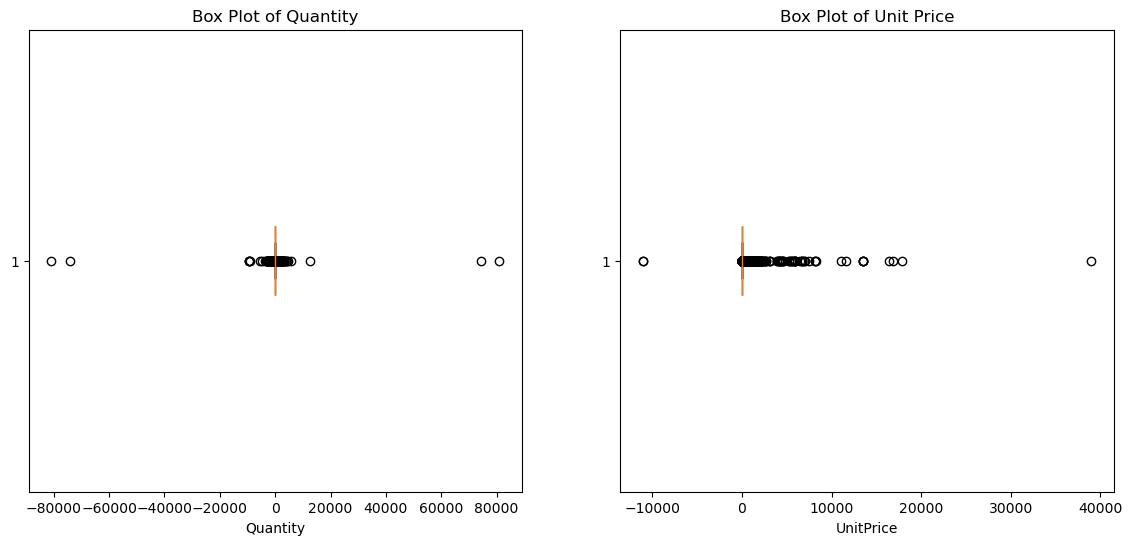

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].boxplot(ecommerce['Quantity'], vert=False, patch_artist=True)
ax[0].set_title('Box Plot of Quantity')
ax[0].set_xlabel('Quantity')

ax[1].boxplot(ecommerce['UnitPrice'], vert=False, patch_artist=True)
ax[1].set_title('Box Plot of Unit Price')
ax[1].set_xlabel('UnitPrice')

plt.show()

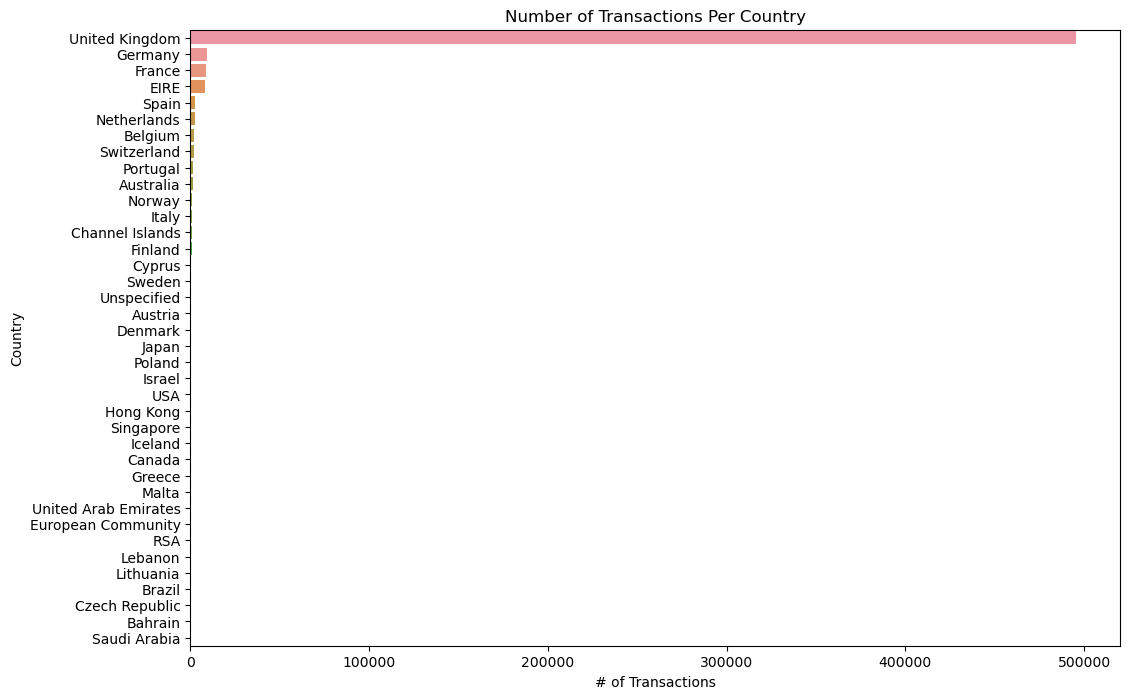

In [12]:
transactions_per_country = ecommerce.groupby('Country').size().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=transactions_per_country.values, y=transactions_per_country.index)
plt.title('Number of Transactions Per Country')
plt.xlabel('# of Transactions')
plt.ylabel('Country')
plt.show()

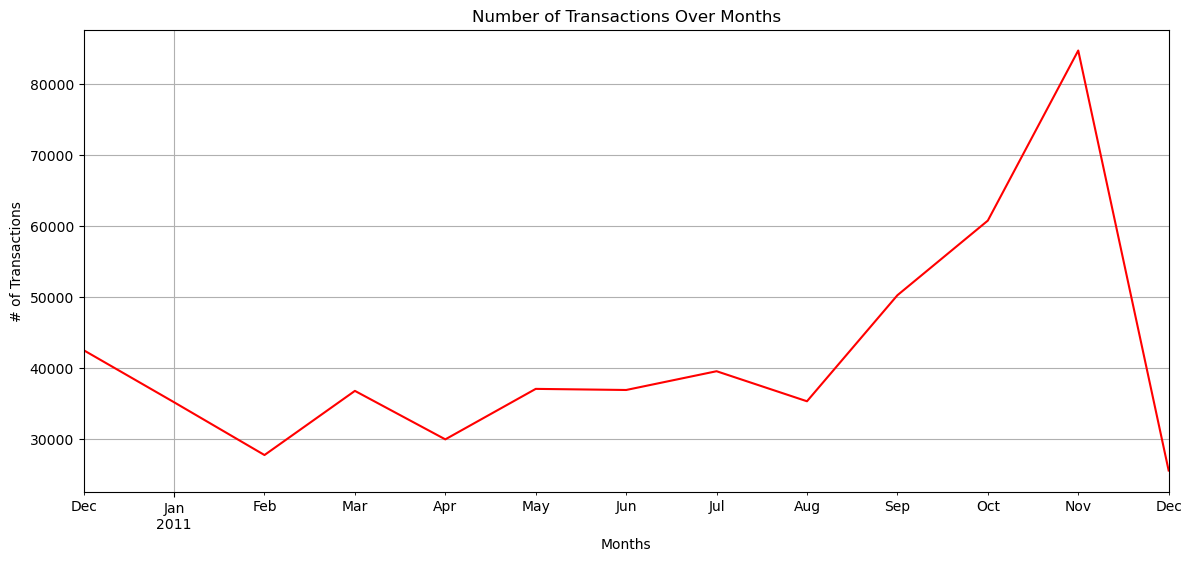

In [13]:
ecommerce['InvoiceDate'] = pd.to_datetime(ecommerce['InvoiceDate'])
transactions_per_month = ecommerce.resample('M', on='InvoiceDate').size()

plt.figure(figsize=(14, 6))
transactions_per_month.plot(color = "red")
plt.title('Number of Transactions Over Months')
plt.xlabel('Months')
plt.ylabel('# of Transactions')
plt.grid(True)
plt.show()

top_selling_products = ecommerce.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
ecommerce['TotalSale'] = ecommerce['Quantity'] * ecommerce['UnitPrice']
sales_by_country = ecommerce.groupby('Country')['TotalSale'].sum().sort_values(ascending=False)

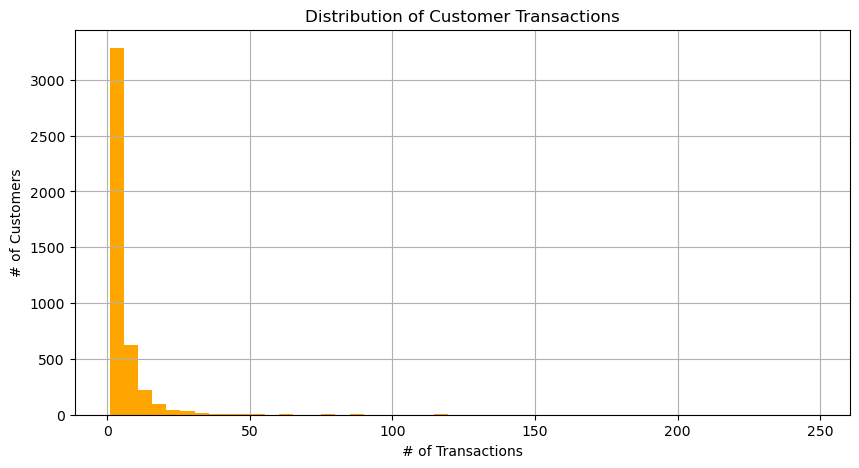

In [14]:
customertransaction = ecommerce.groupby('CustomerID')['InvoiceNo'].nunique()

customertransaction.hist(bins=50, figsize=(10, 5), color='orange')
plt.title('Distribution of Customer Transactions')
plt.xlabel('# of Transactions')
plt.ylabel('# of Customers')
plt.show()

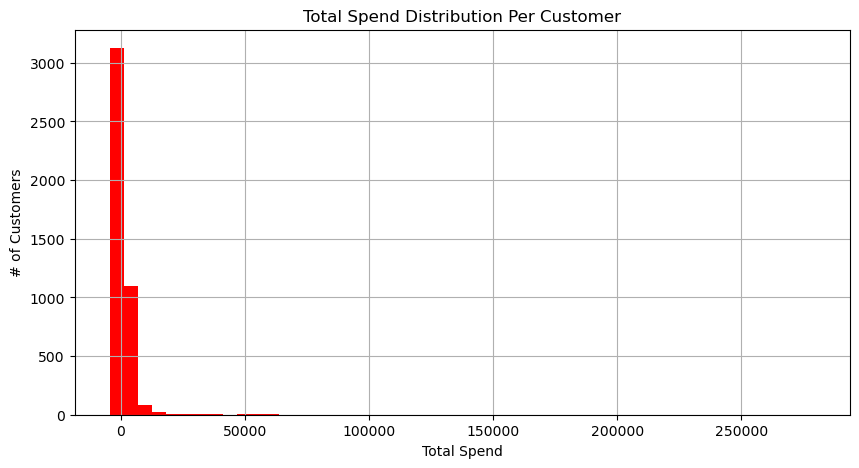

In [15]:
totalspend = ecommerce.groupby('CustomerID')['TotalSale'].sum()

totalspend.hist(bins=50, figsize=(10, 5), color='red')
plt.title('Total Spend Distribution Per Customer')
plt.xlabel('Total Spend')
plt.ylabel('# of Customers')
plt.show()

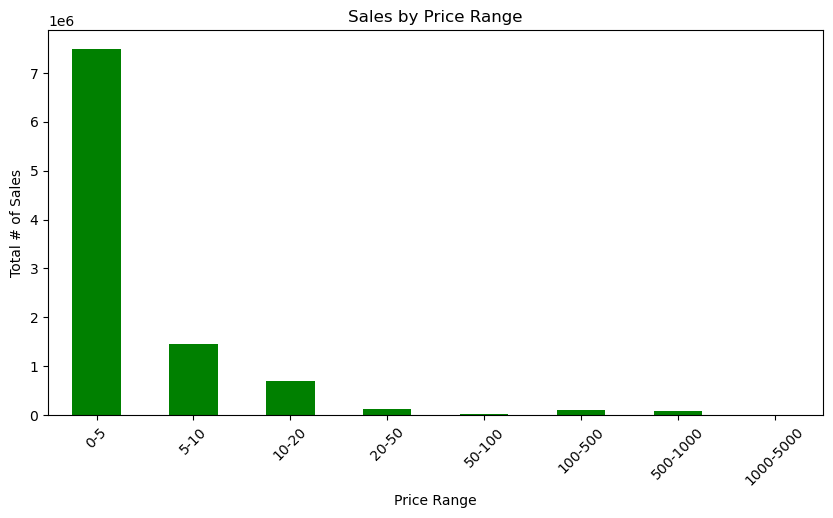

In [16]:
bins = [0, 5, 10, 20, 50, 100, 500, 1000, 5000]
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-500', '500-1000', '1000-5000']
ecommerce['PriceRange'] = pd.cut(ecommerce['UnitPrice'], bins=bins, labels=labels, right=False)

pricerange_sale = ecommerce.groupby('PriceRange')['TotalSale'].sum()

pricerange_sale.plot(kind='bar', figsize=(10, 5), color='green')
plt.title('Sales by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Total # of Sales')
plt.xticks(rotation=45)
plt.show()

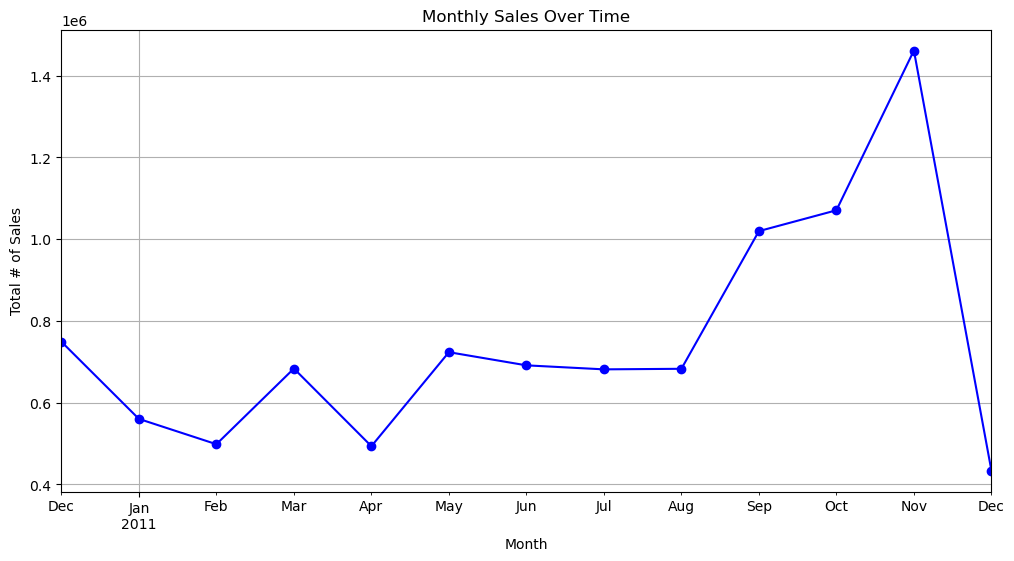

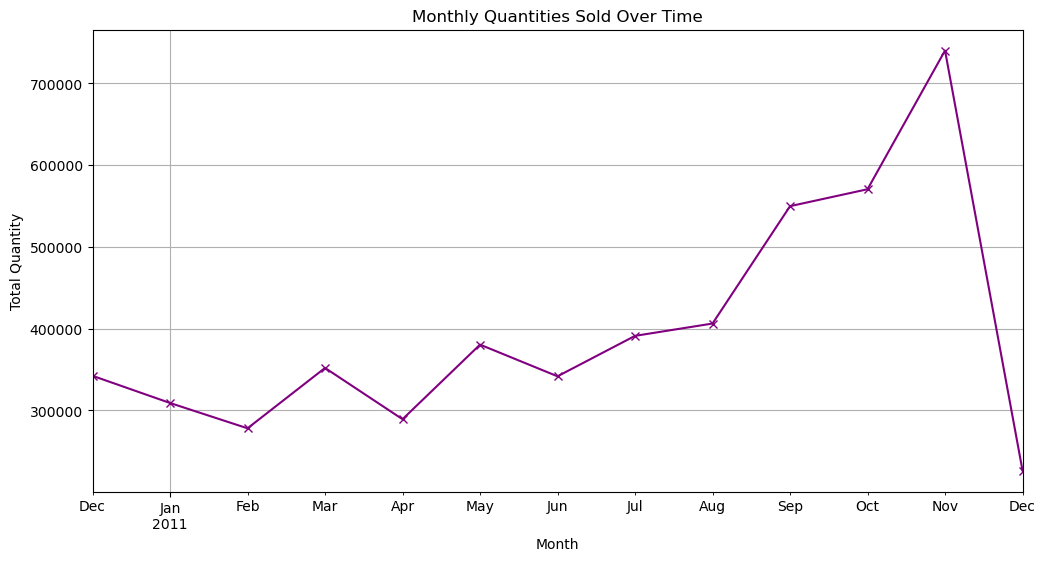

In [17]:
monthly_sales = ecommerce.resample('M', on='InvoiceDate')['TotalSale'].sum()
monthly_quantities = ecommerce.resample('M', on='InvoiceDate')['Quantity'].sum()

monthly_sales.plot(figsize=(12, 6), marker='o', linestyle='-', color='blue')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total # of Sales')
plt.grid(True)
plt.show()

monthly_quantities.plot(figsize=(12, 6), marker='x', linestyle='-', color='purple')
plt.title('Monthly Quantities Sold Over Time')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()

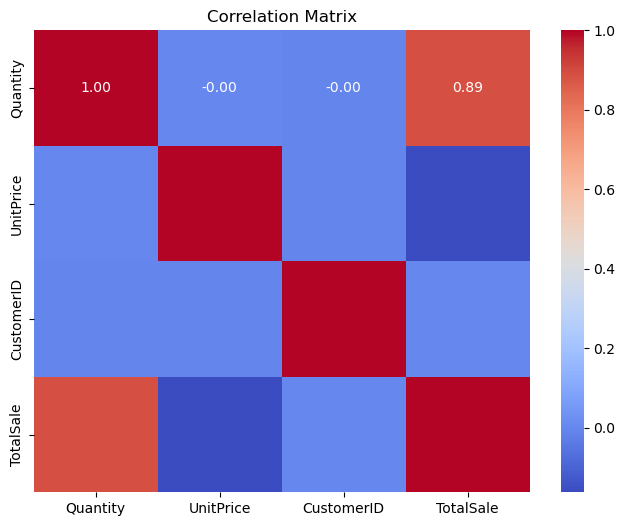

In [18]:
numerical_data = ecommerce.select_dtypes(include=['number'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

[Back to Top](#home)

# **Association Rules Algorithm** <a class="anchor" id="Association-Rules-Algorithm"></a>

#### *Pre-Processing* <a class="anchor" id="Pre-Processing"></a>

In [19]:
ecommerce.dropna(inplace=True)

In [20]:
ecommerce['Description'] = ecommerce['Description'].str.strip()
#ecommerce.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
ecommerce['InvoiceNo'] = ecommerce['InvoiceNo'].astype('str')
ecommerce = ecommerce[ecommerce['Country'] != 'Unspecified']

In [21]:
ecommerce.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalSale      0
PriceRange     0
dtype: int64

In [22]:
ecommerce.shape

(406581, 10)

[Back to Top](#home)

#### *Baskets* <a class="anchor" id="Baskets"></a>

In [23]:
ecommerce['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Brazil', 'USA', 'European Community', 'Bahrain', 'Malta', 'RSA'],
      dtype=object)

In [24]:
continent_mapping = {
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Australia': 'Australia',
    'Netherlands': 'Europe',
    'Germany': 'Europe',
    'Norway': 'Europe',
    'EIRE': 'Europe',
    'Switzerland': 'Europe',
    'Spain': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Italy': 'Europe',
    'Belgium': 'Europe',
    'Lithuania': 'Europe',
    'Japan': 'Asia',
    'Iceland': 'Europe',
    'Channel Islands': 'Europe',
    'Denmark': 'Europe',
    'Cyprus': 'Europe',
    'Sweden': 'Europe',
    'Austria': 'Europe',
    'Israel': 'Asia',
    'Finland': 'Europe',
    'Bahrain': 'Asia',
    'Greece': 'Europe',
    'Hong Kong': 'Asia',
    'Singapore': 'Asia',
    'Lebanon': 'Asia',
    'United Arab Emirates': 'Asia',
    'Saudi Arabia': 'Asia',
    'Czech Republic': 'Europe',
    'Canada': 'North America',
    'Brazil': 'South America',
    'USA': 'North America',
    'European Community': 'Europe',
    'Malta': 'Europe',
    'RSA': 'Africa'
}

In [25]:
ecommerce['Continent'] = ecommerce['Country'].map(continent_mapping)

In [26]:
ecommerce.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSale,PriceRange,Continent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,0-5,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,0-5,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe


In [27]:
continent_basket = {}

for continent in ecommerce['Continent'].unique():
    basket = (ecommerce[ecommerce['Continent'] == continent]
              .groupby(['InvoiceNo', 'Description'])['Quantity']
              .sum().unstack().reset_index().fillna(0)
              .set_index('InvoiceNo'))
    continent_basket[continent] = basket

In [28]:
continent_basket['Europe'].head(3)

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
536366,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
536367,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [29]:
basket.columns

Index(['4 TRADITIONAL SPINNING TOPS', 'ALARM CLOCK BAKELIKE RED',
       'ASSORTED BOTTLE TOP  MAGNETS', 'BAKING SET 9 PIECE RETROSPOT',
       'BELLE JARDINIERE CUSHION COVER', 'BIRDHOUSE GARDEN MARKER',
       'CARD HOLDER LOVE BIRD SMALL', 'CHARLOTTE BAG VINTAGE ALPHABET',
       'CHILDRENS TOY COOKING UTENSIL SET', 'CLASSIC GLASS COOKIE JAR',
       'CLASSIC METAL BIRDCAGE PLANT HOLDER', 'CREAM SWEETHEART MINI CHEST',
       'DOORMAT KEEP CALM AND COME IN', 'DOORMAT UNION FLAG',
       'DOORSTOP RETROSPOT HEART', 'GREEN METAL BOX ARMY SUPPLIES',
       'GUMBALL COAT RACK', 'IVORY KITCHEN SCALES', 'JAM MAKING SET WITH JARS',
       'JUMBO BAG ALPHABET', 'JUMBO BAG RED RETROSPOT',
       'JUMBO BAG VINTAGE DOILY', 'JUMBO SHOPPER VINTAGE RED PAISLEY',
       'LUNCH BAG PINK POLKADOT', 'LUNCH BAG RED RETROSPOT',
       'LUNCH BAG VINTAGE DOILY', 'Manual', 'PACK OF 6 BIRDY GIFT TAGS',
       'PARTY BUNTING', 'PINK  POLKADOT PLATE',
       'PINK FAIRY CAKE CHILDRENS APRON', 'PINK HAPPY B

[Back to Top](#home)

#### *Top 10 Association Rules for Europe* <a class="anchor" id="Top-10-Association-Rules-for-Europe"></a>

In [30]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets_Europe = continent_basket['Europe'].applymap(encode_units).astype(bool)

frequent_itemsets_Europe = apriori(basket_sets_Europe, min_support=0.01, use_colnames=True)

rules_Europe = association_rules(frequent_itemsets_Europe, metric="lift", min_threshold = 1)
 
rules_Europe[ (rules_Europe['lift'] >= 60) &
       (rules_Europe['confidence'] >= 0.7) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


[Back to Top](#home)

In [31]:
sorted_rules_Europe = rules_Europe.sort_values('lift', ascending=False)
top_10_rules_Europe = sorted_rules_Europe.head(10)

#### *Top 10 Frequent Item Sets (Bundles of At Least 2) - Based on Relative Support* <a class="anchor" id="Top-10-Frequent-Item-Sets-(Bundles-of-At-Least-2)-Based-on-Relative-Support"></a>

In [32]:
frequent_itemsets_Europe['length'] = frequent_itemsets_Europe['itemsets'].apply(lambda x: len(x))
itemsets_at_least_2 = frequent_itemsets_Europe[frequent_itemsets_Europe['length'] >= 2]

In [33]:
sorted_itemsets = itemsets_at_least_2.sort_values('support', ascending=False)
top_10_itemsets = sorted_itemsets.head(10)

[Back to Top](#home)

#### *Marketing Insights* <a class="anchor" id="Marketing-Insights"></a>

In [34]:
top_10_rules_Europe.round(2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
351,(REGENCY TEA PLATE ROSES),(REGENCY TEA PLATE GREEN),0.010,0.010,0.010,0.700,57.900,0.010,3.280,1.000
350,(REGENCY TEA PLATE GREEN),(REGENCY TEA PLATE ROSES),0.010,0.010,0.010,0.850,57.900,0.010,6.390,0.990
362,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.010,0.010,0.010,0.730,56.940,0.010,3.600,1.000
363,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.010,0.010,0.010,0.830,56.940,0.010,5.770,1.000
333,(POPPY'S PLAYHOUSE KITCHEN),(POPPY'S PLAYHOUSE BEDROOM),0.020,0.010,0.010,0.730,51.210,0.010,3.710,1.000
332,(POPPY'S PLAYHOUSE BEDROOM),(POPPY'S PLAYHOUSE KITCHEN),0.010,0.020,0.010,0.800,51.210,0.010,5.020,0.990
364,(SMALL MARSHMALLOWS PINK BOWL),(SMALL DOLLY MIX DESIGN ORANGE BOWL),0.010,0.020,0.010,0.780,48.000,0.010,4.550,0.990
365,(SMALL DOLLY MIX DESIGN ORANGE BOWL),(SMALL MARSHMALLOWS PINK BOWL),0.020,0.010,0.010,0.630,48.000,0.010,2.630,1.000
39,(BLUE HAPPY BIRTHDAY BUNTING),(PINK HAPPY BIRTHDAY BUNTING),0.020,0.020,0.010,0.710,45.010,0.010,3.400,0.990
38,(PINK HAPPY BIRTHDAY BUNTING),(BLUE HAPPY BIRTHDAY BUNTING),0.020,0.020,0.010,0.710,45.010,0.010,3.420,0.990


In [35]:
top_10_itemsets

,support,itemsets,length
570,0.025,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA...",2
541,0.024,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",2
508,0.024,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK...",2
636,0.024,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",2
606,0.023,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU...",2
686,0.021,"(WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FR...",2
640,0.021,"(LUNCH BAG SPACEBOY DESIGN, LUNCH BAG RED RETR...",2
605,0.021,"(LUNCH BAG PINK POLKADOT, LUNCH BAG BLACK SKU...",2
536,0.021,"(GARDENERS KNEELING PAD KEEP CALM, GARDENERS K...",2
627,0.021,"(LUNCH BAG RED RETROSPOT, LUNCH BAG CARS BLUE)",2


In [36]:
proportion = (top_10_itemsets['support'] * 100).round(2)

In [37]:
top_10_itemsets.insert(1, 'itemset_transactions_proportion', proportion)

In [38]:
top_10_itemsets

,support,itemset_transactions_proportion,itemsets,length
570,0.025,2.470,"(JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA...",2
541,0.024,2.410,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",2
508,0.024,2.380,"(ALARM CLOCK BAKELIKE RED, ALARM CLOCK BAKELIK...",2
636,0.024,2.350,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",2
606,0.023,2.340,"(LUNCH BAG RED RETROSPOT, LUNCH BAG BLACK SKU...",2
686,0.021,2.120,"(WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FR...",2
640,0.021,2.110,"(LUNCH BAG SPACEBOY DESIGN, LUNCH BAG RED RETR...",2
605,0.021,2.100,"(LUNCH BAG PINK POLKADOT, LUNCH BAG BLACK SKU...",2
536,0.021,2.090,"(GARDENERS KNEELING PAD KEEP CALM, GARDENERS K...",2
627,0.021,2.070,"(LUNCH BAG RED RETROSPOT, LUNCH BAG CARS BLUE)",2


In [39]:
top_10_itemsets.values

array([[0.024725523999637056, 2.47,
        frozenset({'JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT'}),
        2],
       [0.024135740858361312, 2.41,
        frozenset({'GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER'}),
        2],
       [0.023772797386807005, 2.38,
        frozenset({'ALARM CLOCK BAKELIKE RED', 'ALARM CLOCK BAKELIKE GREEN'}),
        2],
       [0.023545957717085564, 2.35,
        frozenset({'LUNCH BAG RED RETROSPOT', 'LUNCH BAG PINK POLKADOT'}),
        2],
       [0.023409853915252698, 2.34,
        frozenset({'LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'}),
        2],
       [0.02118682515198258, 2.12,
        frozenset({'WOODEN FRAME ANTIQUE WHITE', 'WOODEN PICTURE FRAME WHITE FINISH'}),
        2],
       [0.021096089284094004, 2.11,
        frozenset({'LUNCH BAG SPACEBOY DESIGN', 'LUNCH BAG RED RETROSPOT'}),
        2],
       [0.020959985482261138, 2.1,
        frozenset({'LUNCH BAG PINK POLKADOT', 'LUNCH BAG  BLACK SKULL.

[Back to Top](#home)

# **K-Means** <a class="anchor" id="K-Means"></a>

#### *Pre-Processing* <a class="anchor" id="Pre-Processing-2"></a>

In [40]:
cluster_data = ecommerce[ecommerce['Continent'] == 'Europe']

In [41]:
cluster_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSale,PriceRange,Continent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,0-5,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,0-5,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe


In [42]:
cluster_data.shape

(403813, 11)

In [43]:
cluster_data['Country'].unique()

array(['United Kingdom', 'France', 'Netherlands', 'Germany', 'Norway',
       'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy',
       'Belgium', 'Lithuania', 'Iceland', 'Channel Islands', 'Denmark',
       'Cyprus', 'Sweden', 'Austria', 'Finland', 'Greece',
       'Czech Republic', 'European Community', 'Malta'], dtype=object)

In [44]:
cluster_data.duplicated().sum()

5218

Duplicate Rows

In [45]:
duplicate_rows = cluster_data[cluster_data.duplicated(keep=False)]

In [46]:
duplicate_rows_count = duplicate_rows.shape[0]
duplicate_rows_sample = duplicate_rows.head()

In [47]:
duplicate_rows_sample

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSale,PriceRange,Continent
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.950,17908.000,United Kingdom,4.950,0-5,Europe
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.100,17908.000,United Kingdom,2.100,0-5,Europe
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.250,17908.000,United Kingdom,1.250,0-5,Europe
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.250,17908.000,United Kingdom,1.250,0-5,Europe
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.950,17908.000,United Kingdom,2.950,0-5,Europe


In [48]:
cluster_data.drop_duplicates(keep='first')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSale,PriceRange,Continent
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom,15.300,0-5,Europe
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom,22.000,0-5,Europe
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom,20.340,0-5,Europe
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.850,12680.000,France,10.200,0-5,Europe
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.100,12680.000,France,12.600,0-5,Europe
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600,0-5,Europe
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.150,12680.000,France,16.600,0-5,Europe


[Back to Top](#home)

#### *Feature Engineering* <a class="anchor" id="Feature-Engineering"></a>

In [49]:
cluster_data['InvoiceDate'] = pd.to_datetime(cluster_data['InvoiceDate'])

In [50]:
cluster_data['TotalAmount'] = cluster_data['Quantity'] * cluster_data['UnitPrice']

In [51]:
cluster_data = cluster_data[cluster_data["Quantity"] > 0]

In [52]:
cluster_data['CustomerID'] = cluster_data['CustomerID'].astype('object')

In [53]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395144 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    395144 non-null  object        
 1   StockCode    395144 non-null  object        
 2   Description  395144 non-null  object        
 3   Quantity     395144 non-null  int64         
 4   InvoiceDate  395144 non-null  datetime64[ns]
 5   UnitPrice    395144 non-null  float64       
 6   CustomerID   395144 non-null  object        
 7   Country      395144 non-null  object        
 8   TotalSale    395144 non-null  float64       
 9   PriceRange   395144 non-null  category      
 10  Continent    395144 non-null  object        
 11  TotalAmount  395144 non-null  float64       
dtypes: category(1), datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 36.6+ MB


Additional Columns

In [54]:
# Total Spend per Customer
total_spend = cluster_data.groupby('CustomerID')['TotalAmount'].sum().rename('TotalAmount')

In [55]:
# Purchase Frequency
purchase_frequency = cluster_data.groupby('CustomerID')['InvoiceNo'].nunique().rename('PurchaseFrequency')

In [56]:
# Average Basket Size
average_basket_size = cluster_data.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].sum().groupby('CustomerID').mean().rename('AverageBasketSize')

In [57]:
# Total Spend per Customer
total_spend = cluster_data.groupby('CustomerID')['TotalAmount'].sum().rename('TotalAmount')

In [58]:
# Recency of Purchase
reference_date = cluster_data['InvoiceDate'].max()
most_recent_purchase = cluster_data.groupby('CustomerID')['InvoiceDate'].max()
recency_of_purchase = (reference_date - most_recent_purchase).dt.days.rename('RecencyOfPurchase')

In [59]:
features_df = pd.concat([total_spend, purchase_frequency, average_basket_size, recency_of_purchase], axis=1).fillna(0)

In [60]:
features_df

,TotalAmount,PurchaseFrequency,AverageBasketSize,RecencyOfPurchase
CustomerID,,,,
12346.000,77183.600,1,74215.000,325
12347.000,4310.000,7,351.143,1
12348.000,1797.240,4,585.250,74
12349.000,1757.550,1,631.000,18
12350.000,334.400,1,197.000,309
...,...,...,...,...
18280.000,180.600,1,45.000,277
18281.000,80.820,1,54.000,180
18282.000,178.050,2,51.500,7


In [61]:
cluster_data['Season'] = cluster_data['InvoiceDate'].dt.month%12 // 3 + 1
seasonal_purchases = pd.get_dummies(cluster_data['Season'], prefix='Season').groupby(cluster_data['CustomerID']).mean()

In [62]:
additional_features = [seasonal_purchases]
customer_features = features_df.join(additional_features)

In [63]:
customer_features

,TotalAmount,PurchaseFrequency,AverageBasketSize,RecencyOfPurchase,Season_1,Season_2,Season_3,Season_4
CustomerID,,,,,,,,
12346.000,77183.600,1,74215.000,325,1.000,0.000,0.000,0.000
12347.000,4310.000,7,351.143,1,0.390,0.132,0.220,0.258
12348.000,1797.240,4,585.250,74,0.742,0.161,0.000,0.097
12349.000,1757.550,1,631.000,18,0.000,0.000,0.000,1.000
12350.000,334.400,1,197.000,309,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...
18280.000,180.600,1,45.000,277,0.000,1.000,0.000,0.000
18281.000,80.820,1,54.000,180,0.000,0.000,1.000,0.000
18282.000,178.050,2,51.500,7,0.417,0.000,0.583,0.000


[Back to Top](#home)

#### *Train/Test Split* <a class="anchor" id="Train/Test-Split"></a>

In [64]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

In [65]:
X_train, X_test = train_test_split(scaled_features, test_size=0.25, random_state=42)

[Back to Top](#home)

#### *K-Means Solution* <a class="anchor" id="K-Means-Solution"></a>

In [66]:
inertia = []

k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

Scree

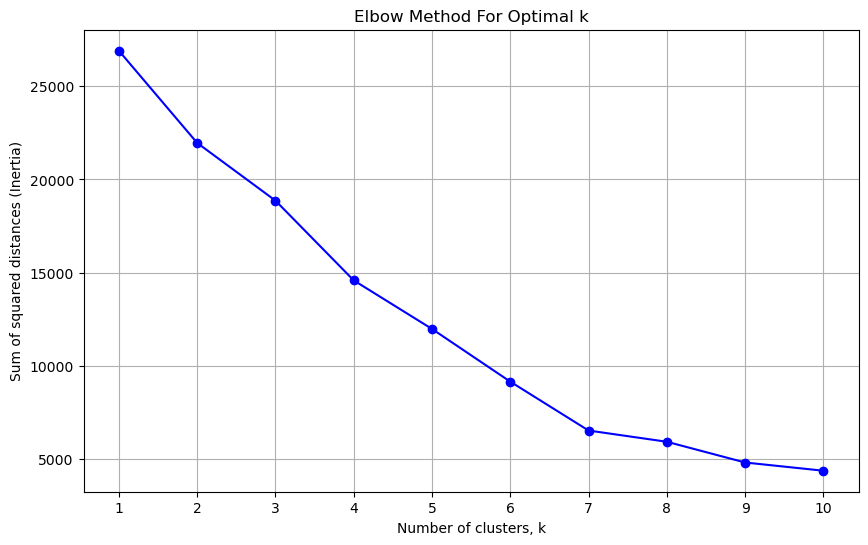

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters, k')
plt.ylabel('Sum of squared distances (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

[Back to Top](#home)

#### *Choosing K* <a class="anchor" id="Choosing-K"></a>

In [68]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

KMeans(n_clusters=3, random_state=42)

In [69]:
test_labels = kmeans.predict(X_test)
train_labels = kmeans.predict(X_train)

In [70]:
train_silhouette = silhouette_score(X_train, kmeans.labels_)
test_silhouette = silhouette_score(X_test, test_labels)

In [71]:
print("Training Set Silhouette Score:", train_silhouette)
print("\nTest Set Silhouette Score:", test_silhouette)

Training Set Silhouette Score: 0.32179985083270607

Test Set Silhouette Score: 0.33988712239805347


[Back to Top](#home)

#### *Cluster Interpretations / Marketing Insights* <a class="anchor" id="Cluster-Interpretations/Marketing-Insights"></a>

In [72]:
unique_train, counts_train = np.unique(train_labels, return_counts=True)
train_cluster_sizes = dict(zip(unique_train, counts_train))

In [73]:
unique_test, counts_test = np.unique(test_labels, return_counts=True)
test_cluster_sizes = dict(zip(unique_test, counts_test))

In [74]:
print("Training Cluster Sizes:", train_cluster_sizes)
print("\nTest Cluster Sizes:", test_cluster_sizes)

Training Cluster Sizes: {0: 1596, 1: 1256, 2: 373}

Test Cluster Sizes: {0: 509, 1: 420, 2: 146}


In [75]:
proportions_train = {k: v / sum(counts_train) for k, v in train_cluster_sizes.items()}
proportions_test = {k: v / sum(counts_test) for k, v in test_cluster_sizes.items()}

In [76]:
print("Training Data Proportions:", proportions_train)
print("\nTest Data Proportions:", proportions_test)

Training Data Proportions: {0: 0.4948837209302326, 1: 0.38945736434108524, 2: 0.11565891472868217}

Test Data Proportions: {0: 0.47348837209302325, 1: 0.39069767441860465, 2: 0.13581395348837208}


In [77]:
clusters = kmeans.fit_predict(scaled_features)

In [78]:
cluster_data_unscaled = pd.DataFrame(scaler.inverse_transform(scaled_features))

In [79]:
cluster_data_unscaled["cluster"] = clusters
cluster_data_unscaled.head(5)

,0,1,2,3,4,5,6,7,cluster
0,77183.600,1.000,74215.000,325.000,1.000,0.000,0.000,0.000,2
1,4310.000,7.000,351.143,1.000,0.390,0.132,0.220,0.258,0
2,1797.240,4.000,585.250,74.000,0.742,0.161,0.000,0.097,1
3,1757.550,1.000,631.000,18.000,0.000,0.000,0.000,1.000,0
4,334.400,1.000,197.000,309.000,1.000,0.000,0.000,0.000,1


In [80]:
cluster_data_unscaled.columns = list(customer_features.columns) + ['ClusterLabel']

In [81]:
cluster_data_unscaled.rename(columns={
    'Season_1': 'Winter',
    'Season_2': 'Spring',
    'Season_3': 'Summer',
    'Season_4': 'Fall'
}, inplace=True)

In [82]:
cluster_data_unscaled['PurchaseFrequency'] = cluster_data_unscaled['PurchaseFrequency'].astype(int)
cluster_data_unscaled['RecencyOfPurchase'] = cluster_data_unscaled['RecencyOfPurchase'].astype(int)

In [83]:
cluster_data_unscaled

,TotalAmount,PurchaseFrequency,AverageBasketSize,RecencyOfPurchase,Winter,Spring,Summer,Fall,ClusterLabel
0,77183.600,1,74215.000,325,1.000,0.000,0.000,0.000,2
1,4310.000,7,351.143,1,0.390,0.132,0.220,0.258,0
2,1797.240,4,585.250,74,0.742,0.161,0.000,0.097,1
3,1757.550,1,631.000,18,0.000,0.000,0.000,1.000,0
4,334.400,1,197.000,309,1.000,0.000,0.000,0.000,1
...,...,...,...,...,...,...,...,...,...
4295,180.600,1,45.000,277,0.000,1.000,0.000,0.000,0
4296,80.820,1,54.000,180,0.000,0.000,1.000,0.000,0
4297,178.050,2,51.500,7,0.417,0.000,0.583,0.000,0
4298,2094.880,16,87.312,3,0.241,0.132,0.222,0.405,0


In [84]:
unscaled_centroids = scaler.inverse_transform(kmeans.cluster_centers_)
unscaled_centroids

array([[2.15340110e+03, 4.63115846e+00, 2.32793609e+02, 6.83696405e+01,
        1.11158465e-01, 2.27015126e-01, 2.12653285e-01, 4.49173124e-01],
       [6.46038729e+02, 1.88950276e+00, 1.84156199e+02, 2.48108656e+02,
        8.96808615e-01, 6.58963396e-02, 3.12234405e-02, 6.07160506e-03],
       [1.22828050e+05, 1.50000000e+00, 5.73567500e+04, 1.62500000e+02,
        6.66666667e-01, 3.33333333e-01, 0.00000000e+00, 0.00000000e+00]])

In [85]:
def create_centroid_df(centroids, feature_names):
    return pd.DataFrame(centroids, columns=feature_names)

In [86]:
kmeans_centroids_df = create_centroid_df(unscaled_centroids, customer_features.columns)

In [87]:
kmeans_centroids_df

,TotalAmount,PurchaseFrequency,AverageBasketSize,RecencyOfPurchase,Season_1,Season_2,Season_3,Season_4
0,2153.401,4.631,232.794,68.370,0.111,0.227,0.213,0.449
1,646.039,1.890,184.156,248.109,0.897,0.066,0.031,0.006
2,122828.050,1.500,57356.750,162.500,0.667,0.333,0.000,0.000


[Back to Top](#home)

In [88]:
warnings.filterwarnings("default")